In [1]:
include("../src/geosteering.jl");
include("../src/mdp.jl");
include("../src/utils.jl");


In [2]:
#set seed for reproducibility
rng = MersenneTwister(5) 

#initialize the MDP model
gs = initialize_mdp(
    rng=rng, size=(10, 10), 
    base_amplitude=2.0, 
    target_thickness=3.0, 
    vertical_shift=5.0,
    drift_prob=0.01)

GeoSteeringMDP
  size: Tuple{Int64, Int64}
  base_amplitude: Float64 2.0
  base_frequency: Float64 1.0
  amplitude_variation: Float64 0.5
  frequency_variation: Float64 0.05
  phase: Float64 0.3
  vertical_shift: Float64 5.0
  target_reward: Float64 5.0
  target_thickness: Float64 3.0
  nontarget_penalty: Float64 -2.0
  drift_prob: Float64 0.01
  discount: Float64 0.95
  reward_target: Float64 100.0
  reward_redundant_target: Float64 0.0
  reward_offtarget: Float64 -100.0
  rng: MersenneTwister
  target_zone: Set{SVector{2, Int64}}
  shale_zone: Set{SVector{2, Int64}}
  nontarget_zone: Set{SVector{2, Int64}}
  terminal_zone: Set{SVector{2, Int64}}


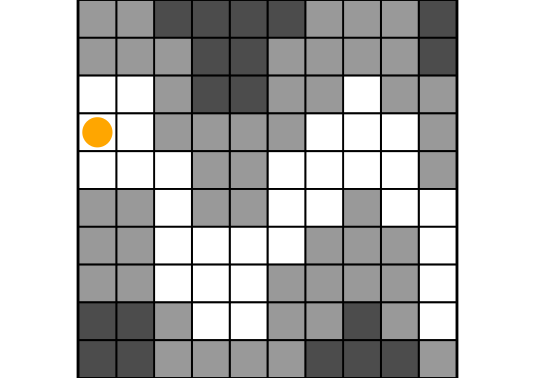

In [3]:
# one simulation step example
p0 = initialstate(gs) # initial state distribution
s = rand(rng, p0) # initial state s ~ p0

#plot the initial state
render(gs, (s=s,))

In this 10x10 grid problem, white cells mean target zone, light gray cells mean shale zone, and darker gray cells mean harder rock. The goal is to determine the sequence of drill directions (forward, top, or bottom) from orange circle location to other end of the target zone to maximize surface coverage of the drill path.

## MDP Model Components

### State Space

In this simple 10x10 problem, the state $s$ is simply the location (x, y) and binaries whether the surface area has been drilled or not. The number of all possible combinations for the state is already huge!

In [4]:
𝒮 = states(gs)

#example of states
[println(𝒮[i]) for i in 1:3] 

println("The size of the state space is: ", length(𝒮))

State
  cell: SVector{2, Int64}
  is_surface_visited: Array{Bool}((10,)) Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

State
  cell: SVector{2, Int64}
  is_surface_visited: Array{Bool}((10,)) Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

State
  cell: SVector{2, Int64}
  is_surface_visited: Array{Bool}((10,)) Bool[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

The size of the state space is: 103424


### Action space

The action space is relatively small, with only 4 possible actions: move forward (`RIGHT`), `UP` or `DOWN`.

In [5]:
𝒜 = actions(gs)

(UP, DOWN, RIGHT)

### Transition function

The transition function in this problem is simple: whenever we take a drill action, we move toward the direction of that action with probability $1-p_\text{drift}$, and got drifted to random location with probability $p_\text{drift}$. However, we aren't able to go out of bounds of the system.

Also, the first time we visit a new surface area (new x-coordinate), we set the Boolean visited status of that surface area to be `true`, otherwise it stays at default value `false`

We can simulate a state transition as follows.

In [6]:
# we can take random action from the action space

a = rand(rng, 𝒜) # random action
p = transition(gs, s, a) # get next state distribution p(s' | s, a)
sp = rand(rng, p) # the next state is sampled from this s ~ p

println("From state s with location ", s.cell, " we took action ", a, " and ended up in state ", sp.cell)
println("The surface visit status is updated from ", s.is_surface_visited, " to ", sp.is_surface_visited)

From state s with location [1, 7] we took action RIGHT and ended up in state [2, 7]
The surface visit status is updated from Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0] to Bool[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Had we taken an action RIGHT, we will have the following:

In [7]:
a_alt = RIGHT
p_alt = transition(gs, s, a_alt) # get next state distribution p(s' | s, a)
sp_alt = rand(rng, p_alt) # the next state is sampled from this s ~ p

println("From state s with location ", s.cell, " we took action ", a_alt, " and ended up in state ", sp_alt.cell)
println("The surface visit status is updated from ", s.is_surface_visited, " to ", sp_alt.is_surface_visited)

From state s with location [1, 7] we took action RIGHT and ended up in state [2, 7]
The surface visit status is updated from Bool[1, 0, 0, 0, 0, 0, 0, 0, 0, 0] to Bool[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


### Reward Function

The reward function `reward(s,a)` or `reward(s,a,sp)` tells the reward we get if from state `s` we take an action `a` and end up at next state `sp`. 

In [8]:
r = reward(gs, s, a, sp)
println("The reward for taking action ", a, " from state ", s.cell, " and ending up in state ", sp.cell, " is ", r)

r_alt = reward(gs, s, a_alt, sp_alt)
println("The reward for taking action ", a_alt, " from state ", s.cell, " and ending up in state ", sp_alt.cell, " is ", r_alt)

The reward for taking action RIGHT from state [1, 7] and ending up in state [2, 7] is -100.0
The reward for taking action RIGHT from state [1, 7] and ending up in state [2, 7] is -100.0


### Solving the model

With this model, we can try a bunch of approaches to come up with a policy. For MDP, a policy is simply a mapping from state to action. You can think of it as a look up table that prescribes the optimal action to take at every state that maximize our objective.

For this problem, we can formulate the objective as maximizing long-term cumulative reward of staying in the target zone:

\begin{align}
\text{maximize}~ \sum_{t=1}^T r_t \gamma^{t-1},
\end{align}

where $r_t$ is the reward at time $t$ and $\gamma \in [0, 1]$ is the discount factor that reflects how much we weigh more immediate rewards vs. future ones.

We can compare two types of solvers to obtain such an optimized policy: offline solver and online solver.

In [9]:
#offline planner example
using DiscreteValueIteration

solver = ValueIterationSolver(max_iterations=100);
@time policy = solve(solver, gs);

 35.066333 seconds (1.30 G allocations: 44.564 GiB, 5.90% gc time, 2.60% compilation time)


┌ Info: Saved animation to /home/mansur/Work/MineralX/GeoSteerings.jl/figs/SimPolicyVI.gif
└ @ Plots /home/mansur/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/home/mansur/Work/MineralX/GeoSteerings.jl/figs/SimPolicyVI.gif")
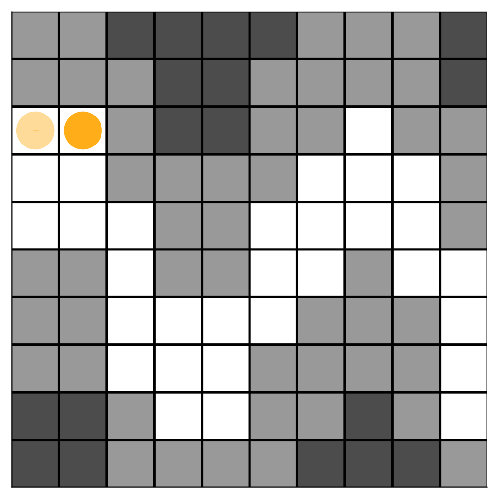

In [10]:
# simulate the policy
hr = HistoryRecorder(max_steps=30, rng=rng)
hist = simulate(hr, gs, policy)

# render and save the plots as png images and gif animation
plot_sim_steps = render(gs, hist);
num_steps = length(plot_sim_steps)
[savefig(plot_sim_steps[i], gs.size, "../figs/SimRollout$i.png") for i in 1:num_steps];
create_gif_from_images(dir="../figs/", gif_name="SimPolicyVI.gif", fps=2, num_steps=num_steps) 

  0.029725 seconds (35.38 k allocations: 2.471 MiB, 99.75% compilation time)
  0.614743 seconds (6.27 M allocations: 365.027 MiB, 11.01% gc time, 58.53% compilation time)


┌ Info: Saved animation to /home/mansur/Work/MineralX/GeoSteerings.jl/figs/SimPolicyMCTS.gif
└ @ Plots /home/mansur/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/home/mansur/Work/MineralX/GeoSteerings.jl/figs/SimPolicyMCTS.gif")
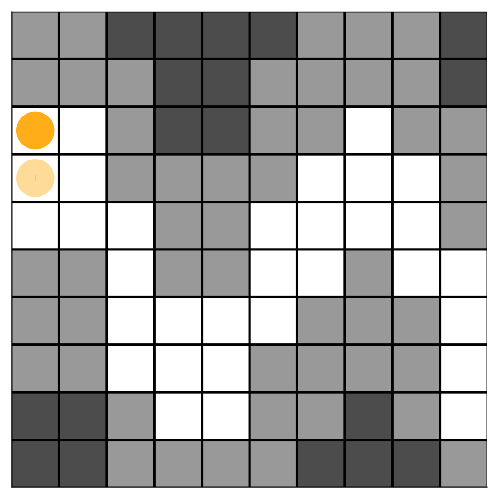

In [11]:
#offline planner example
using MCTS

solver = MCTSSolver(n_iterations=1000, depth=30, rng=rng)
@time mcts_policy = solve(solver, gs);

#simulate and render the policy
@time hist = simulate(hr, gs, mcts_policy)

# render and save the plots as png images and gif animation
plot_sim_steps = render(gs, hist);
num_steps = length(plot_sim_steps)
[savefig(plot_sim_steps[i], gs.size, "../figs/SimRollout$i.png") for i in 1:num_steps];
create_gif_from_images(dir="../figs/", gif_name="SimPolicyMCTS.gif", fps=2, num_steps=num_steps) 

In this example, we see that the offline solver (`Discrete Value Iteration`) runs much longer compared to the online solver (`Monte Carlo Tree Search or MCTS`). However, offline solvers oftentimes solve the optimal policy (with higher objective) vs. online solvers. This is the tradeoff that we have to make in practice, especially as we deal with larger state and action spaces.

In the coming practices, we will try a handful of approaches to solve the model more optimally.